<a href="https://colab.research.google.com/github/arghyadeep99/KhetiAI/blob/master/Crop_Disease_Detection_using_Resnet50_on_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os,json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

keras = tf.keras

TensorFlow 2.x selected.


In [3]:
# verify TensorFlow version

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")


Version:  2.0.0-rc0
Eager mode:  True
GPU is available


In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

In [5]:
cd drive/My Drive/PlantVillage/

/content/drive/My Drive/PlantVillage


In [6]:
ls

apks/                              plants_disease_checkpoint_mobilenet.pth
categories.json                    plants_disease_checkpoint_name_graph.pb
export.pkl                         plants_disease_checkpoint_name.onnx
keras_inceptionv3.h5               plants_disease_checkpoint.pth
keras_resnet50_crop_prediction.h5  ResNet50/
labels.txt                         resnet50_crop_prediction.tflite
MobileNet/                         saved_models/
models/                            testing/
model_v2_final1.h5                 tflite_models/
model_v2_final2.h5                 tflite_models_updated/
nodename.txt                       train/
plant_disease.tflite               val/
plants_disease_checkpoint_101.pth


In [7]:
with open('categories.json', 'r') as f:
    cat_to_name = json.load(f)
    classes=list(cat_to_name.values())
    print(classes)
    print(len(classes))

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [0]:
DATASET='/content/drive/My Drive/PlantVillage/'
TRAIN_DATA=DATASET+'train'
VAL_DATA=DATASET+'val'
TEST_DATA=DATASET+'testing'
BATCH_SIZE=64
IMAGE_SIZE=(224,224)
#MODULE_HANDLE ="https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/3"

In [0]:
IMG_SHAPE = (224,224,3)

# Create the base model from the pre-trained model ResNet50
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.summary()
print("Number of layers in ResNet50 are: ", len(base_model.layers))
layer_names=list(base_model.layers)
layer_names=[str(l) for l in layer_names]
layers_names=[]
for i in layer_names:
  i=i.split(".")
  #print(i)
  i[5]=i[5].split(" ")[0]
  i[0]=i[0][1:]
  i='.'.join(i)
  layers_names.append(i)
  #print(i)
print(layers_names)
print(len(layers_names))

94773248/94765736 [==============================] - 4s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [9]:
# Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    VAL_DATA, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=(224,224),
    batch_size=BATCH_SIZE)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=(224,224),
    batch_size=BATCH_SIZE)


Found 11014 images belonging to 39 classes.
Found 35252 images belonging to 39 classes.


In [0]:
model = tf.keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(data_format=None),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

In [0]:
do_fine_tuning = True #@param {type:"boolean"}
#fine_tune_at=145
if do_fine_tuning:
  base_model.trainable=True
  j=1
  for layer,model_layer in zip(base_model.layers[0:176],layers_names):
    if model_layer!='tensorflow.python.keras.layers.normalization.BatchNormalization':
      layer.trainable =  False
    else:
      layer.trainable = True
      print("BN layer{} unfreezed.".format(j))
      j=j+1
else:
  base_model.trainable=False

BN layer1 unfreezed.
BN layer2 unfreezed.
BN layer3 unfreezed.
BN layer4 unfreezed.
BN layer5 unfreezed.
BN layer6 unfreezed.
BN layer7 unfreezed.
BN layer8 unfreezed.
BN layer9 unfreezed.
BN layer10 unfreezed.
BN layer11 unfreezed.
BN layer12 unfreezed.
BN layer13 unfreezed.
BN layer14 unfreezed.
BN layer15 unfreezed.
BN layer16 unfreezed.
BN layer17 unfreezed.
BN layer18 unfreezed.
BN layer19 unfreezed.
BN layer20 unfreezed.
BN layer21 unfreezed.
BN layer22 unfreezed.
BN layer23 unfreezed.
BN layer24 unfreezed.
BN layer25 unfreezed.
BN layer26 unfreezed.
BN layer27 unfreezed.
BN layer28 unfreezed.
BN layer29 unfreezed.
BN layer30 unfreezed.
BN layer31 unfreezed.
BN layer32 unfreezed.
BN layer33 unfreezed.
BN layer34 unfreezed.
BN layer35 unfreezed.
BN layer36 unfreezed.
BN layer37 unfreezed.
BN layer38 unfreezed.
BN layer39 unfreezed.
BN layer40 unfreezed.
BN layer41 unfreezed.
BN layer42 unfreezed.
BN layer43 unfreezed.
BN layer44 unfreezed.
BN layer45 unfreezed.
BN layer46 unfreeze

In [0]:
model.layers

In [0]:
#Compile model specifying the optimizer learning rate

LEARNING_RATE = 0.0001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 39)                20007     
Total params: 24,656,807
Trainable params: 1,122,215
Non-trainable params: 23,534,592
_________________________________________________________________


In [0]:
len(model.trainable_variables)

110

In [0]:
EPOCHS=10 #@param {type:"integer"}
init_epoch=5
history = model.fit_generator(train_generator,
                         epochs=EPOCHS,
                         steps_per_epoch=train_generator.samples//train_generator.batch_size,
                         initial_epoch=0,
                         validation_data=validation_generator,
                         validation_steps=validation_generator.samples//validation_generator.batch_size)

In [10]:
from keras.models import load_model
#model.save('keras_resnet50_crop_prediction.h5')
model=keras.models.load_model('keras_resnet50_crop_prediction.h5')
model.summary()

Using TensorFlow backend.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 39)                20007     
Total params: 24,656,807
Trainable params: 1,122,215
Non-trainable params: 23,534,592
_________________________________________________________________


In [0]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [0]:
print("Training accuracy is: {}%".format(acc[-1]*100))
print("Validation accuracy is: {}%".format(val_acc[-1]*100))

Training accuracy is: 97.86859154701233%
Validation accuracy is: 97.5744903087616%


In [0]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(TRAIN_DATA, VAL_DATA, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: Peach___Bacterial_spot, file: Peach___Bacterial_spot/b07c6d99-19b0-40c5-9aff-69d7abfd6e74___Rut._Bact.S 0939.JPG
PREDICTED: class: Peach___Bacterial_spot, confidence: 0.686970


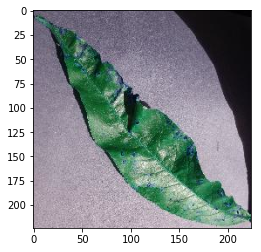

<Figure size 432x288 with 0 Axes>

SOURCE: class: Tomato___Spider_mites Two-spotted_spider_mite, file: Tomato___Spider_mites Two-spotted_spider_mite/4423cc33-fa85-4d37-bc9f-b0ee47e55607___Com.G_SpM_FL 1714.JPG
PREDICTED: class: Tomato___Spider_mites Two-spotted_spider_mite, confidence: 0.963099


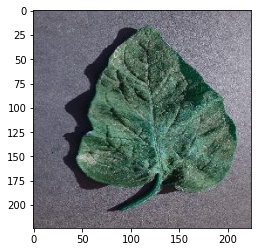

SOURCE: class: Soybean___healthy, file: Soybean___healthy/bd2b1ad0-dbea-4fdf-a278-dcd73db78585___RS_HL 5613.JPG
PREDICTED: class: Soybean___healthy, confidence: 0.702504


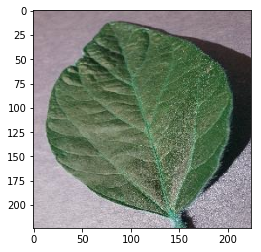

<Figure size 432x288 with 0 Axes>

SOURCE: class: Corn_(maize)___Common_rust_, file: Corn_(maize)___Common_rust_/RS_Rust 2494.JPG
PREDICTED: class: Corn_(maize)___Common_rust_, confidence: 0.999682


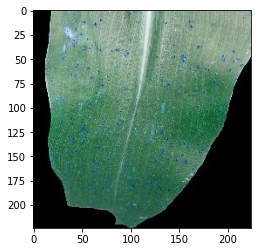

<Figure size 432x288 with 0 Axes>

SOURCE: class: Grape___Esca_(Black_Measles), file: Grape___Esca_(Black_Measles)/ecb4cc57-0f87-4392-9810-dc5a3b05ed56___FAM_B.Msls 1194.JPG
PREDICTED: class: Grape___Esca_(Black_Measles), confidence: 0.995603


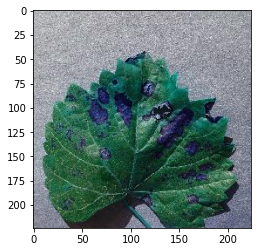

<Figure size 432x288 with 0 Axes>

In [12]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [0]:
from tensorflow.contrib import lite
converter = lite.TFLiteConverter.from_keras_model_file( 'keras_resnet50_crop_prediction.h5' ) # Your model's name
lite_model = converter.convert()
file = open( 'keras_latest_resnet50.tflite' , 'wb' ) 
file.write(lite_model)